[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/02_cnn_edge_lover.ipynb)

# A simple CNN for the edge lover task
**Storytime:** There is an artlover who only likes images with vertical stripes. The goal of this notebook is to use an algorithm (CNN) which helps to classify if the art lover likes the image or not.

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/refs/heads/main/notebooks/art_lover.png" alt="Sample Image" width="150">

**Task:**
You train a very simple CNN with only 1 kernel to distinguish between images containing vertical and images containing horizontal stripes. To check what pattern is recognized by the learned kernel you will visualize the weights of the kernel as an image. You will see that the CNN learns a useful kernel (either a vertical or horiziontal bar). You can experiment with the code to check the influence of the kernel size, the activation function and the pooling method on the result.  


**Dataset:** You work with an artficially generated dataset of greyscale images (50x50 pixel) with 10 vertical or horizontal bars. We want to classify them into whether the art lover, who only loves vertical strips, will like the image (y = 0) or not like the image (y = 1).  

The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Content:**
* definig and generating the dataset X_train and X_val
* visualize samples of the generated images
* use keras to train a CNN with only one kernel (5x5 pixel)
* visualize the weights of the learned kernel and interpret if it is useful
* repeat the last two steps to check if the learned kernel is always the same



### Imports

In the next cell, we load all the required libraries.

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] ="torch"
import keras
import torch
print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

# Keras Building blocks
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers


Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch


### Defining functions to generate images

Here we define the function to genere images with vertical and horizontal bars, the arguments of the functions are the size of the image and the number of bars you want to have. The bars are at random positions in the image with a random length. The image is black and white, meaning we have only two values for the pixels, 0 for black and 255 for white.

In [2]:
#define function to generate image with shape (size, size, 1) with stripes
def generate_image_with_bars(size, bar_nr, vertical = True):
    img = np.zeros((size,size,1), dtype="uint8")
    for i in range(0,bar_nr):
        x,y = np.random.randint(0,size,2)
        l  = int(np.random.randint(y,size,1)[0])
        if (vertical):
            img[y:l,x,0]=255
        else:
            img[x,y:l,0]=255
    return img

Let's have a look at the generated images. We choose a size of 50x50 pixels and set the number of bars in the image to 10.

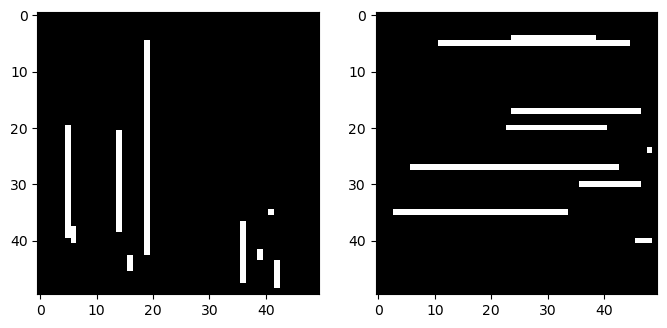

In [3]:
# have a look on two generated images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=generate_image_with_bars(50,10, vertical=True)
plt.imshow(img[:,:,0],cmap='gray')
plt.subplot(1,2,2)
img=generate_image_with_bars(50,10, vertical=False)
plt.imshow(img[:,:,0],cmap='gray')
plt.show()

### Make a train and validation dataset of images with vertical and horizontal images
Now, let's make a train dataset *X_train* with 1000 images (500 images with vertical and 500 images with horizontal bars). We normalize the images values to be between 0 and 1 by dividing all values with 255. We create a secont dataste *X_val* with exactly the same properties to validate the training of the CNN.

In [4]:
pixel=50  # define height and width of images
num_images_train = 1000 #Number of training examples (divisible by 2)
num_images_val = 1000 #Number of training examples (divisible by 2)

# generate training data with vertical edges
X_train =np.zeros((num_images_train,pixel,pixel,1))
for i in range(0, num_images_train//2):
    X_train[i]=generate_image_with_bars(pixel,10)
# ... with horizontal
for i in range(num_images_train//2, num_images_train):
    X_train[i]=generate_image_with_bars(pixel,10, vertical=False)

# generate validation data with vertical edges
X_val =np.zeros((num_images_train,pixel,pixel,1))
for i in range(0, num_images_train//2):
    X_val[i]=generate_image_with_bars(pixel,10)
# ... with horizontal
for i in range(num_images_train//2, num_images_train):
    X_val[i]=generate_image_with_bars(pixel,10, vertical=False)

In [5]:
# normalize the data to be between 0 and 1
X_train=X_train/255
X_val=X_val/255

print(X_train.shape, " min ", np.min(X_train), " max ", np.max(X_train))
print(X_val.shape)

(1000, 50, 50, 1)  min  0.0  max  1.0
(1000, 50, 50, 1)


Here we make the labels for the art lover, 0 means he likes the image (vertical bars) and 1 means that he doesn't like it (horizontal stripes). We one hot encode the labels because we want to use two outputs in our network.

In [6]:
# create class labels
y = np.array([[0],[1]])
Y_train = np.repeat(y, num_images_train //2)
Y_val = np.repeat(y, num_images_train //2)

# one-hot-encoding
#Y_train = to_categorical(Y_train,2)
#Y_val = to_categorical(Y_val,2)
print(Y_train.shape, " min ", np.min(Y_train), " max ", np.max(Y_train))

(1000,)  min  0  max  1


## Defining the CNN

Here we define the CNN:

- we use only one kernel with a size of 5x5 pixels  
- then we apply a linar activation function  
- the maxpooling layer takes the maximum of the whole activation map to predict the probability (output layer with sigmoid) if the art lover will like the image

As loss we use the binary_crossentropy and we train the model with a batchsize of 64 images per update.


In [7]:
model = Sequential()

model.add(Convolution2D(1,(5,5),padding='same',input_shape=(pixel,pixel,1)))
model.add(Activation('linear'))

# take the max over all values in the activation map
model.add(MaxPooling2D(pool_size=(pixel,pixel)))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model and initialize weights
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


/Users/oli/miniconda3/envs/dlwbl_eth25_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# let's summarize the CNN architectures along with the number of model weights
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 1)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
%%time
# train the model
history=model.fit(X_train, Y_train,
                  validation_data=(X_val,Y_val),
                  batch_size=64,
                  epochs=50,
                  verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4943 - loss: 0.8140 - val_accuracy: 0.5000 - val_loss: 0.7571
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5229 - loss: 0.7255 - val_accuracy: 0.5000 - val_loss: 0.7081
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5130 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6714
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5036 - loss: 0.6655 - val_accuracy: 0.5000 - val_loss: 0.6425
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4931 - loss: 0.6487 - val_accuracy: 0.5000 - val_loss: 0.6204
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5168 - loss: 0.6047 - val_accuracy: 0.5000 - val_loss: 0.6003
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5093 - loss: 0.5943 - val_accuracy: 0.5000 - val_loss: 0.5810
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5173 - loss: 0.5669 - val_accuracy: 0.5000 - v

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

## 🔧 **YOUR TASK:**

### Visualize the learned kernel and experiment with the code

- You see that the CNN performs very good at this task (100% accuracy). We can check which pattern is recognized by the **learned kernel** and see if you think that this is helpful to distinguish between images with horizontal and vertical edges.

- Below you can see the original image, the image after the convolution operation with the learned kernel and the maximum value from the maxpooling operation. Note that the maxpooling has the same size as the convolved image so there is just one value as output.


- Move the sliders to inspect different pictures from the validation set and their predictions


In [12]:
# @title Random Kernel and Kernel learned based on the data { display-mode: "form" }
## Do not worry about this cell, just move the sliders.
import scipy.signal
from skimage.measure import block_reduce  # For max pooling
import ipywidgets as widgets

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.random.rand(25).reshape(5, 5),"gray") ,plt.title('Randomly initalized weights')
plt.subplot(1, 2, 2)
conv_filter=np.squeeze(model.get_weights()[0], axis=2)
plt.imshow(conv_filter[:,:,0],"gray"),plt.title('Learned Kernel (weights) , by model'),plt.show();

def scale_convolution_map(conv_map, min_val=-3, max_val=3):
    clipped_conv_map = np.clip(conv_map, min_val, max_val)
    scaled_conv_map = (clipped_conv_map - min_val) / (max_val - min_val)
    return scaled_conv_map

def plot_conv(img,category):
  convolved_image = scipy.signal.convolve2d(img.squeeze(), conv_filter.squeeze(), mode='same')
  scaled_conv_image = scale_convolution_map(convolved_image + model.get_weights()[1])
  max_pooled_image = block_reduce(convolved_image + model.get_weights()[1], block_size=(50, 50), func=np.max)
  scaled_max_pooled_image = scale_convolution_map(max_pooled_image)

  plt.figure(figsize=(20, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img, "gray", vmin=0, vmax=1),plt.title('Original Image')
  plt.subplot(1, 6, 2)
  plt.imshow(scaled_conv_image, "gray", vmin=0, vmax=1),plt.title('Convolved Image')
  plt.subplot(1, 6, 3),plt.imshow(scaled_max_pooled_image, "gray", vmin=0, vmax=1)
  plt.title(f'Max Pooled = {max_pooled_image[0][0]:.2f}'),plt.xticks([]), plt.yticks([])
  plt.subplot(1, 6, 4),plt.axis('off')
  pred = model.predict(img.reshape(1, 50, 50, 1), verbose=0)
  if category=="vertical":
    text_info = f'''
    P(y=vertical|x): {pred[0][0]:.4f}
    P(y=horizontal|x): {pred[0][1]:.4f}


    loss component:  {-np.log(pred[0][0]):.4f}
      '''
  else:
        text_info = f'''
    P(y=vertical|x): {pred[0][0]:.4f}
    P(y=horizontal|x): {pred[0][1]:.4f}


    loss component:  {-np.log(pred[0][1]):.4f}
      '''

  plt.text(0, 0.5, text_info, ha='left', va='center')
  plt.subplot(1, 6, 5)
  x_values = np.linspace(0.001, 1.1, 500)
  plt.plot(x_values, -np.log(x_values), label='-log(P(y|x))')
  plt.ylim(-0.5, 6),plt.xlim(-0.1, 1.1),plt.xlabel('P(y|x)')
  if category=="vertical":
    plt.plot(pred[0][0], -np.log(pred[0][0]), 'bo', label='loss component')
  else:
    plt.plot(pred[0][1], -np.log(pred[0][1]), 'ro', label='loss component')

  plt.legend(),plt.grid(True), plt.tight_layout(),plt.show()

def inspect_preds(idx,category='vertical'):
  plot_conv(X_val[idx,:,:,0],category)

ModuleNotFoundError: No module named 'skimage'

In [13]:
horizontal_slider = widgets.IntSlider(min=0, max=num_images_val//2-1, step=1, value=0, description='vertical')
widgets.interact(inspect_preds, idx=horizontal_slider,category=widgets.fixed('vertical'));

NameError: name 'widgets' is not defined

In [ ]:
vertical_slider = widgets.IntSlider(min=num_images_val//2, max=num_images_val-1, step=1, value=0, description='horizontal')
widgets.interact(inspect_preds, idx=vertical_slider,category=widgets.fixed('horizontal'));

### Excercise 1

Given the probabilities, calculate the loss component for one example of your choice from the validation set.

<details>
  <summary>🔑 Click here to View Answers:</summary>

assumed that we have a vertical image,  label = *vertical* or translated to numbers label = *0*

assume that probabilites by the model for said example are:

 $p_{model}(y=0|image
) = 0.9$


The NLL for a sample is given by: $ l_{i}= -log(p_{model}(y_{i}|x_{i})) $

The loss: $loss = \frac{1}{N} \sum_{}{} li$



$ = - \left[ \log(0.9) \right]$

$ =  0.1053 $


</details>

### Excercise 2


- Repeat the compiling and training, beginning from the cell:

```
model = Sequential()
       
       ...
       
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
```

For several times and check if the CNN.

Does the CNN always learn the same kernel?

<details>
  <summary>🔑 Click here to View Answers:</summary>
- No it does not, sometimes it learns the horizontal patterns, and sometimes the vertical pattern.
</details>

### Additional Excercise

- You can experiment with the code and check what happens if you use another kernel size, Number of Kernels,  activation function (relu instead of linear ) or pooling method AveragePooling instead of MaxPooling.  Try to make a prediction on the performance before doing the experiment.

<details>
  <summary>🔑 Click here to View Answers:</summary>
- if a second kernels is applied the loss converges much faster!
</details>

In [ ]:
model = Sequential()

model.add(Convolution2D(2,(5,5),padding='same',input_shape=(pixel,pixel,1)))
model.add(Activation('relu'))

# take the max over all values in the activation map
model.add(MaxPooling2D(pool_size=(pixel,pixel)))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

# compile model and initialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# train the model
history=model.fit(X_train, Y_train,
                  validation_data=(X_val,Y_val),
                  batch_size=64,
                  epochs=150,
                  verbose=1)

# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')